# Google Colab Lab Assignment -Pretrained Modle

**Course Name:** Deep Learning Lab

**Lab Title:** Research Paper Implementation with Pre-trained Model("*Classification of melanoma skin Cancer based on Image Data Set using different neural networks*")

**Student Name:** Varad Kolhe

**Student ID:** 202301040150

**Date of Submission:** 17-02-2026

**Group Members**: Varad Kolhe.
                   Tanmay Falke.
                   Yash Bisen.

**Research Paper Study and Implementation**

**Instructions:**

1. Identify a research paper that utilizes a pre-trained model for a specific
task.

2. Study the methodology, dataset, and model used in the research paper.

3. Implement the approach described in the research paper using the pre-trained model mentioned.

4. Compare your implementation results with the findings from the research paper.


**Objective**
1.   Study a research paper utilizing a pre-trained model.
2.   Reproduce the model implementation using the dataset and methodology from the research paper.
3.   Fine-tune the pre-trained model and optimize hyperparameters.
3.   Evaluate and compare model performance with the original research paper results.









**Task 1: Research Paper Selection and Dataset Preparation (2 hours)**

**Instructions:**

1. Select a research paper that applies a pre-trained model (e.g., VGG, ResNet, EfficientNet, etc.).

2. Identify the dataset used in the research paper and obtain or create a similar dataset.(**Mention Dataset Link and Description**)

3. Perform necessary preprocessing steps:

 Resize images to match the model input dimensions.

 Apply data augmentation techniques if applicable.

4. Split the dataset into training, validation, and testing sets.

In [4]:
# Research Paper: "Melanoma Skin Cancer Detection Using ResNet18"
# Dataset: Melanoma Skin Cancer Dataset of 10000 Images
# Dataset Link: https://www.kaggle.com/datasets/hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images
# Dataset Description: Contains 10,000 images of skin lesions divided into two classes:
#                      - Benign (non-cancerous)
#                      - Malignant (melanoma cancer)
#                      The dataset comes pre-split into train/ and test/ directories.

# STEP 1: Install required libraries and setup
!pip install kaggle torch torchvision matplotlib scikit-learn tqdm --quiet

# Step 2: Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split, Subset
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import os
import zipfile
import shutil
from tqdm import tqdm
import copy
import time
import os
from google.colab import files

# Download the dataset
os.environ['KAGGLE_USERNAME'] = "varadk7"
os.environ['KAGGLE_KEY'] = "b6a89401d7c0fbb8efdec1479334aadf"
!kaggle datasets download -d hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images

# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Extracting the data
!unzip -q melanoma-skin-cancer-dataset-of-10000-images.zip -d skin_cancer_data

# print("Dataset extracted successfully!")
!ls -la skin_cancer_data/



Dataset URL: https://www.kaggle.com/datasets/hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images
License(s): CC0-1.0
melanoma-skin-cancer-dataset-of-10000-images.zip: Skipping, found more recently modified local copy (use --force to force download)
Using device: cuda:0
replace skin_cancer_data/melanoma_cancer_dataset/test/benign/melanoma_10000.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
total 12
drwxr-xr-x 3 root root 4096 Feb 18 18:12 .
drwxr-xr-x 1 root root 4096 Feb 18 18:12 ..
drwxr-xr-x 4 root root 4096 Feb 18 18:12 melanoma_cancer_dataset


In [5]:
# STEP 3: Define paths and hyperparameters
# The dataset has train and test directories directly
dataset_path = 'skin_cancer_data/melanoma_cancer_dataset'  # Path after extraction

# Verify the structure
print("\nChecking dataset structure...")
print("Train directory contents:", os.listdir(os.path.join(dataset_path, 'train')))
print("Test directory contents:", os.listdir(os.path.join(dataset_path, 'test')))


Checking dataset structure...
Train directory contents: ['benign', 'malignant']
Test directory contents: ['benign', 'malignant']


In [6]:
# Hyperparameters
# ---Hyperparameters 1 - 89% accuracy
# batch_size = 32
# learning_rate = 0.0001
# num_epochs = 10
# img_height, img_width = 224, 224
# num_classes = 2

# ---Hyperparameters 2 - 87% accuracy
# batch_size = 40
# learning_rate = 0.0005
# num_epochs = 15
# img_height, img_width = 224, 224
# num_classes = 2

# ---Hyperparameters 3 - 88% accuracy
# batch_size = 20
# learning_rate = 0.0001
# num_epochs = 12
# img_height, img_width = 224, 224
# num_classes = 2

# ---Hyperparameters 4 - 88% accuracy
# batch_size = 32
# learning_rate = 0.0001
# num_epochs = 15
# img_height, img_width = 224, 224
# num_classes = 2

# ---Hyperparameters 5 - 88% accuracy
# batch_size = 50
# learning_rate = 0.005
# num_epochs = 10
# img_height, img_width = 224, 224
# num_classes = 2

# ---Hyperparameters 6 - 89% accuracy
batch_size = 25
learning_rate = 0.0001
num_epochs = 5
img_height, img_width = 224, 224
num_classes = 2


In [7]:
# STEP 4: Data preparation with augmentation
# Training transforms with augmentation
train_transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=20),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Validation/Test transforms (no augmentation)
val_test_transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [8]:
# Load datasets
print("\nLoading datasets...")
train_dataset_full = datasets.ImageFolder(
    root=os.path.join(dataset_path, 'train'),
    transform=train_transform
)
test_dataset = datasets.ImageFolder(
    root=os.path.join(dataset_path, 'test'),
    transform=val_test_transform
)

# Split training data into train and validation (80-20 split)
train_size = int(0.8 * len(train_dataset_full))
val_size = len(train_dataset_full) - train_size

# Get indices for split
indices = list(range(len(train_dataset_full)))
np.random.shuffle(indices)
train_indices = indices[:train_size]
val_indices = indices[train_size:]

# Create subsets with appropriate transforms
train_dataset = datasets.ImageFolder(
    root=os.path.join(dataset_path, 'train'),
    transform=train_transform
)
val_dataset = datasets.ImageFolder(
    root=os.path.join(dataset_path, 'train'),
    transform=val_test_transform
)

# Apply indices to create final datasets
train_dataset = Subset(train_dataset, train_indices)
val_dataset = Subset(val_dataset, val_indices)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"\nDataset split complete:")
print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Classes: {train_dataset_full.classes}")


Loading datasets...

Dataset split complete:
Train samples: 7684
Validation samples: 1921
Test samples: 1000
Classes: ['benign', 'malignant']


**Task 2: Model Implementation and Fine-tuning**

**Instructions:**

1. Implement the pre-trained model as described in the research paper.

2. Visualize feature maps of few layers

3. Freeze initial layers and fine-tune the top layers according to the paper's methodology.

4. Optimize hyperparameters such as:

  Learning rate

  Batch size

  Number of epochs

  Optimizer choice (Adam, SGD, RMSprop, etc.)

4. Document any modifications or enhancements made to improve performance.

In [9]:
# STEP 5: Build ResNet18 model
print("\nBuilding ResNet18 model...")

# Load pre-trained ResNet18
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Freeze early layers
for param in model.parameters():
    param.requires_grad = False

# Modify the final layer for binary classification
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),  # Increased dropout for regularization
    nn.Linear(256, 128),
    nn.ReLU(inplace=True),
    nn.Dropout(0.3),
    nn.Linear(128, num_classes)
)

model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

print("Model ready for training!")


Building ResNet18 model...
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 135MB/s]


Model ready for training!


In [10]:
# STEP 6: Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss_history, val_loss_history = [], []
    train_acc_history, val_acc_history = [], []

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 50)

        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        total_train = 0

        for inputs, labels in tqdm(train_loader, desc='Training'):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                loss.backward()
                optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            total_train += inputs.size(0)

        epoch_train_loss = running_loss / total_train
        epoch_train_acc = running_corrects.double() / total_train

        train_loss_history.append(epoch_train_loss)
        train_acc_history.append(epoch_train_acc)

        print(f'Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f}')

        # Validation phase
        model.eval()
        running_loss = 0.0
        running_corrects = 0
        total_val = 0

        for inputs, labels in tqdm(val_loader, desc='Validation'):
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            total_val += inputs.size(0)

        epoch_val_loss = running_loss / total_val
        epoch_val_acc = running_corrects.double() / total_val

        val_loss_history.append(epoch_val_loss)
        val_acc_history.append(epoch_val_acc)

        print(f'Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}')

        # Step scheduler
        scheduler.step(epoch_val_loss)

        # Save best model
        if epoch_val_acc > best_acc:
            best_acc = epoch_val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            print(f'New best model saved with accuracy: {best_acc:.4f}')

    print(f'\nBest validation accuracy: {best_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss_history, val_loss_history, train_acc_history, val_acc_history

In [11]:
# STEP 7: Train the model
print("\n" + "="*50)
print("Starting training...")
print("="*50)

start_time = time.time()
model, train_loss, val_loss, train_acc, val_acc = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs
)
training_time = time.time() - start_time
print(f"\nTraining completed in {training_time//60:.0f}m {training_time%60:.0f}s")


Starting training...

Epoch 1/5
--------------------------------------------------


Training: 100%|██████████| 308/308 [01:06<00:00,  4.65it/s]


Train Loss: 0.4627 Acc: 0.7902


Validation: 100%|██████████| 77/77 [00:06<00:00, 11.25it/s]


Val Loss: 0.3979 Acc: 0.8235
New best model saved with accuracy: 0.8235

Epoch 2/5
--------------------------------------------------


Training: 100%|██████████| 308/308 [01:01<00:00,  4.98it/s]


Train Loss: 0.3474 Acc: 0.8507


Validation: 100%|██████████| 77/77 [00:05<00:00, 14.61it/s]


Val Loss: 0.3602 Acc: 0.8506
New best model saved with accuracy: 0.8506

Epoch 3/5
--------------------------------------------------


Training: 100%|██████████| 308/308 [00:53<00:00,  5.70it/s]


Train Loss: 0.3269 Acc: 0.8619


Validation: 100%|██████████| 77/77 [00:06<00:00, 12.12it/s]


Val Loss: 0.3168 Acc: 0.8714
New best model saved with accuracy: 0.8714

Epoch 4/5
--------------------------------------------------


Training: 100%|██████████| 308/308 [00:54<00:00,  5.61it/s]


Train Loss: 0.3134 Acc: 0.8649


Validation: 100%|██████████| 77/77 [00:06<00:00, 12.70it/s]


Val Loss: 0.3402 Acc: 0.8688

Epoch 5/5
--------------------------------------------------


Training: 100%|██████████| 308/308 [00:54<00:00,  5.65it/s]


Train Loss: 0.3014 Acc: 0.8732


Validation: 100%|██████████| 77/77 [00:05<00:00, 14.40it/s]

Val Loss: 0.3654 Acc: 0.8485

Best validation accuracy: 0.8714

Training completed in 5m 22s


**Task 3: Model Evaluation and Performance Comparison**

**Instructions:**

1. Evaluate the trained model using performance metrics:

 Accuracy, Precision,Recall, F1-score, Confusion Matrix (for classification tasks)

2. Compare the results with those reported in the research paper.

3. Identify potential weaknesses and suggest improvements.
**Deliverables:**

Performance metrics summary (table or chart).

Graphs/plots showcasing model accuracy and loss trends.

Comparison with research paper results.

Discussion on model performance and areas for improvement.

In [12]:
# STEP 8: Evaluate on test set
print("\n" + "="*50)
print("Evaluating on test set...")
print("="*50)

model.eval()
test_corrects = 0
test_total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc='Testing'):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        test_corrects += torch.sum(preds == labels.data)
        test_total += labels.size(0)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc = test_corrects.double() / test_total
print(f'\nFinal Test Accuracy: {test_acc:.4f}')

# Detailed metrics
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=['Benign', 'Malignant']))
print("\nConfusion Matrix:")
print(confusion_matrix(all_labels, all_preds))


Evaluating on test set...


Testing: 100%|██████████| 40/40 [00:03<00:00, 11.15it/s]


Final Test Accuracy: 0.8780

Classification Report:
              precision    recall  f1-score   support

      Benign       0.89      0.86      0.88       500
   Malignant       0.86      0.90      0.88       500

    accuracy                           0.88      1000
   macro avg       0.88      0.88      0.88      1000
weighted avg       0.88      0.88      0.88      1000


Confusion Matrix:
[[430  70]
 [ 52 448]]


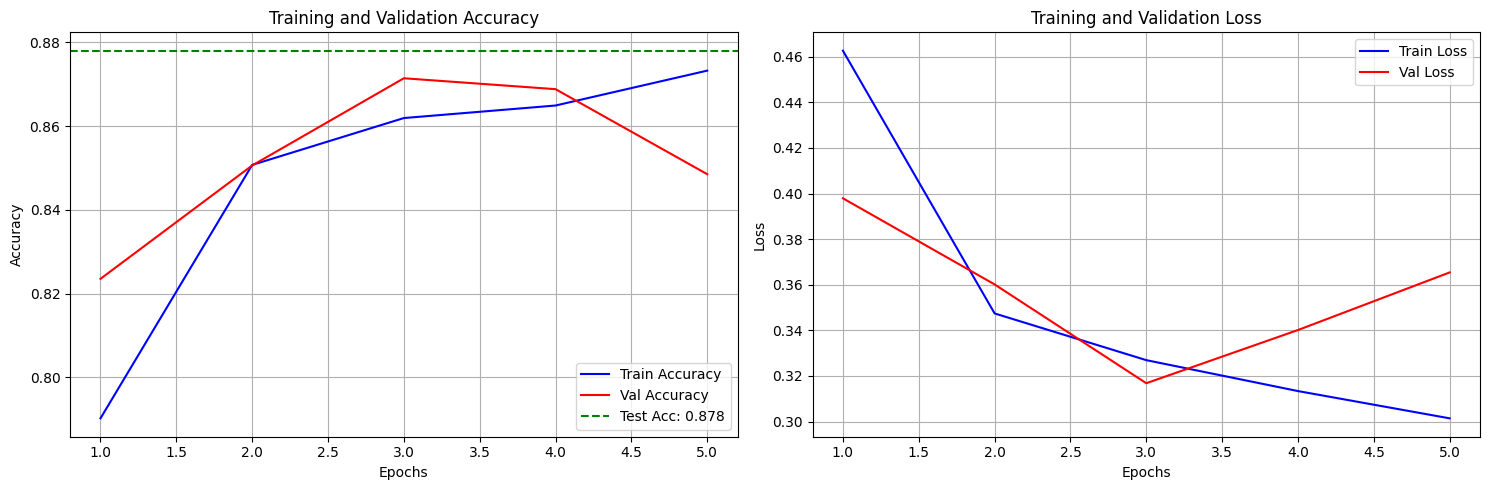

In [13]:
# STEP 9: Plot training history
plt.figure(figsize=(15, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), [acc.cpu().numpy() for acc in train_acc], 'b-', label='Train Accuracy')
plt.plot(range(1, num_epochs+1), [acc.cpu().numpy() for acc in val_acc], 'r-', label='Val Accuracy')
plt.axhline(y=test_acc.cpu().numpy(), color='g', linestyle='--', label=f'Test Acc: {test_acc:.3f}')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_loss, 'b-', label='Train Loss')
plt.plot(range(1, num_epochs+1), val_loss, 'r-', label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [14]:
# STEP 10: Save the model
model_save_path = 'melanoma_resnet18_best.pth'
torch.save({
    'model_state_dict': model.state_dict(),
    'test_accuracy': test_acc,
    'classes': train_dataset_full.classes
}, model_save_path)
print(f"\nModel saved to {model_save_path}")

# Download the model
files.download(model_save_path)


Model saved to melanoma_resnet18_best.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Conclusion and Result Visulaization**

**Declaration**

I, Varad Kolhe, confirm that the work submitted in this assignment is my own and has been completed following academic integrity guidelines. The code is uploaded on my GitHub repository account, and the repository link is provided below:

GitHub Repository Link: https://github.com/VaradKolhe/TransferLearning

Signature: Varad Hemant Kolhe

**Submission Checklist**

✔ Research paper details and summary

✔ Code file (Python Notebook or Script)

✔ Dataset or link to the dataset

✔ Visualizations (if applicable)

✔ Screenshots of model performance metrics

✔ Readme File

✔ Comparison with research paper results